<a href="https://colab.research.google.com/github/manueltonneau/TXTfpbsupervisedBERT/blob/master/Sentence_classification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install Cython

In [0]:
!pip install pytorch-transformers

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

import gc
gc.collect()


270

In [0]:
!pip install pretrainedmodels

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==1.0.52
import fastai

from fastai import *
from fastai.vision import *
from fastai.text import *

from torchvision.models import *
import pretrainedmodels
!pip install utils

from utils import *
import sys

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [0]:
%%bash
pip install pytorch-pretrained-bert

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
from sklearn.model_selection import train_test_split


In [0]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving pre_processed_aapl_sentences.csv to pre_processed_aapl_sentences.csv


In [0]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

In [0]:
train = pd.read_csv("Sentences_AllAgree_preprocessed.csv")#, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [0]:
test = pd.read_csv("pre_processed_aapl_sentences.csv",index_col=None, header=0, engine='python')

In [0]:
test.dropna(inplace=True)

In [0]:

#DATA_ROOT = Path("..") / "input"

#train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test.csv"]]
train_1, val = train_test_split(train, shuffle=True, test_size=0.2, random_state=42)
#train_1, val = train_test_split(train_1, shuffle=True, test_size=0.2, random_state=42)


In [0]:
train.head()

,sentence,label_negative,label_neutral,label_positive
0,"According to Gran , the company has no plans t...",0,1,0
1,Technopolis plans to develop in stages an area...,0,1,0
2,With the new production plant the company woul...,0,0,1
3,According to the company 's updated strategy f...,0,0,1
4,"For the last quarter of 2010 , Componenta 's n...",0,0,1


In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])

In [0]:

label_cols = ["label_negative","label_neutral","label_positive"]

databunch_1 = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="sentence",
                  label_cols=label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [0]:
# this will produce a virtually identical databunch to the code above
databunch_2 = BertDataBunch.from_df(".", train_df=train, valid_df=val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="sentence",
                  label_cols=label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
databunch_1.show_batch()


text,target
"[CLS] supported nokia phones include : n ##9 ##6 , n ##9 ##5 - 8 ##gb , n ##9 ##5 , n ##9 ##3 - n ##9 ##31 , n ##9 ##2 , n ##85 , n ##8 ##2 , n ##8 ##1 , n ##80 , n ##7 ##9 , n ##7 ##8 , n ##7 ##7 , n ##7 ##6 , n ##75 , n ##7 ##3 ,",label_neutral
[CLS] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -,label_neutral
"[CLS] narrows to eu ##r ##2 . 8 m 9 - mo ' 09 29 october 2009 - finnish software and hardware developer el ##ek ##tro ##bit o ##y ##j he ##l : e ##b ##g ##1 ##v , or e ##b , said today that its net loss narrowed to eu ##r ##2 . 8 m for the first nine months of 2009 from eu ##r ##35 . 6",label_positive
"[CLS] mana ##vi ##gat ##or - september 7 , 2010 - ke ##mir ##a un ##ve ##ils indian j ##v with iv ##rc ##l finnish chemicals group ke ##mir ##a ( he ##l : k ##ra ##1 ##v ) on tuesday announced it has ink ##ed a deal to form a joint venture in india with local construction firm iv ##rc ##l infrastructure and projects ltd ( bo ##m :",label_positive
"[CLS] pg ##e bel ##cha ##tow runs the 4 . 44 g ##w bel ##cha ##tow coal - fired power plant , and fort ##um has intentions to start a cc ##s demonstration project jointly with te ##oll ##is ##u ##ude ##n vo ##ima o ##y ##j ( tv ##o ) - another finnish utility - at the their jointly owned 56 ##5 ##m ##w mer ##i - por ##i",label_neutral


# BERT Model

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
from pytorch_transformers import RobertaForSequenceClassification
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
#roberta_model_class = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=3)

100%|██████████| 407873900/407873900 [00:33<00:00, 12271014.95B/s]


In [0]:
loss_func = nn.BCEWithLogitsLoss()

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.25)


In [0]:
model = bert_model_class


In [0]:
from fastai.callbacks import *

learner = Learner(
    databunch_1, model,
    loss_func=loss_func, model_dir='/temp/model', metrics=acc_02,
)

In [0]:
4//3

1

In [0]:
def bert_clas_split(self) -> List[nn.Module]:
    
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer)//3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

In [0]:
x = bert_clas_split(model)


4


In [0]:
learner.split([x[0], x[1], x[2], x[3], x[5]])

Learner(data=TextClasDataBunch;

Train: LabelList (4211 items)
x: TextList
[CLS] according to gran , the company has no plans to move all production to russia , although that is where the company is growing [SEP],[CLS] techno ##polis plans to develop in stages an area of no less than 100 , 000 square meters in order to host companies working in computer technologies and telecommunications , the statement said [SEP],[CLS] with the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profit ##ability [SEP],[CLS] according to the company ' s updated strategy for the years 2009 - 2012 , bas ##ware targets a long - term net sales growth in the range of 20 % - 40 % with an operating profit margin of 10 % - 20 % of net sales [SEP],[CLS] for the last quarter of 2010 , component ##a ' s net sales doubled to eu ##r ##13 ##1 ##m from eu ##r ##7 ##6 ##m for the same peri

In [0]:
learner.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


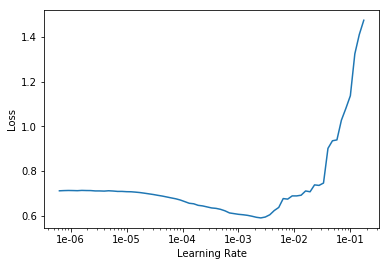

In [0]:
learner.recorder.plot()


In [0]:
learner.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

In [0]:
learner.save('head')
learner.load('head')

In [0]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3,1e-1))

In [0]:
learner.save('head-2')
learner.load('head-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04


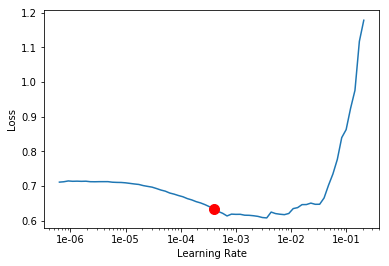

In [0]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
learner.fit_one_cycle(2, slice(5e-6, 5e-5), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3,1e-1))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.412623,0.277589,0.832345,15:02
1,0.250688,0.200606,0.915382,15:00


In [0]:
text = 'The company slipped to an operating loss of EUR 2.6 million from a profit of EUR 1.3 million'
learner.predict(text)

(MultiCategory label_negative,
 tensor([1., 0., 0.]),
 tensor([0.7159, 0.1642, 0.2504]))

In [0]:
text =  "The contract value amounts to EUR 2.4 million"
learner.predict(text)

(MultiCategory label_neutral,
 tensor([0., 1., 0.]),
 tensor([0.0018, 0.9982, 0.0016]))

In [0]:
test.head()

,Unnamed: 0,article_time,Text
0,0,2018-01-02 09:44:59,Apple Inc’s Best Years Are Behind It — Prepare...
1,0,2018-01-02 09:44:59,(NASDAQ: AAPL )? It's a very real possibility
2,0,2018-01-02 09:44:59,The company is running on the fumes of innova...
3,0,2018-01-02 09:44:59,It's now time to seriously consider betting a...
4,0,2018-01-02 09:44:59,"Paul Mampilly, my colleague over at Banyan Hil..."


In [0]:
test.head()

,Unnamed: 0,article_time,Text
0,0,2018-01-02 09:44:59,Apple Inc’s Best Years Are Behind It — Prepare...
1,0,2018-01-02 09:44:59,(NASDAQ: AAPL )? It's a very real possibility
2,0,2018-01-02 09:44:59,The company is running on the fumes of innova...
3,0,2018-01-02 09:44:59,It's now time to seriously consider betting a...
4,0,2018-01-02 09:44:59,"Paul Mampilly, my colleague over at Banyan Hil..."


In [0]:
test["Text"][102]

'3%, at $174'

In [0]:
text =  test["Text"][18]
learner.predict(text)

(MultiCategory label_positive,
 tensor([0., 0., 1.]),
 tensor([0.1146, 0.1848, 0.7609]))

In [0]:
def prediction(x):
  return learner.predict(x)[1].tolist()

In [0]:
def prediction_proba(x):
  return learner.predict(x)[2].tolist()

In [0]:
def transform(x):
  if x[0] == 1:
    return "label_negative"
  elif x[1] == 1:
    return "label_neutral"
  elif x[2] == 1:
    return "label_positive"
  else:
    return "no label"

In [0]:
test["pred"] = test["Text"].apply(prediction)

KeyboardInterrupt: ignored

In [0]:
test.head()

,Unnamed: 0,article_time,Text
0,0,2017-01-03 10:26:00,"Why Apple, Stock Gained 11% in 2016"
1,1,2017-01-03 10:26:00,"Apple(NASDAQ: AAPL) finished 2016 strong, gai..."
2,2,2017-01-03 10:26:00,8%
3,3,2017-01-03 10:26:00,The nice increase toward the end of the year ...
4,4,2017-01-03 10:26:00,"9% rise during the year, according to data pro..."


In [0]:
test["pred_proba"] = test["Text"].apply(prediction_proba)

In [0]:
test.head()

In [0]:
test["true"] = test[["label_negative","label_neutral","label_positive"]].idxmax(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
type(test["pred"][96])

list

In [0]:
test.head()

,sentence,label_negative,label_neutral,label_positive,pred,pred_proba,true
96,"In the fourth quarter of 2008 , net sales incr...",0,0,1,"[0.0, 0.0, 1.0]","[0.07034596800804138, 0.039265722036361694, 0....",label_positive
3305,The contract value amounts to EUR 2.4 million,0,1,0,"[0.0, 1.0, 0.0]","[0.014253164641559124, 0.9578186273574829, 0.0...",label_neutral
811,`` Demand for sports equipment was good in 2005,0,0,1,"[0.0, 0.0, 1.0]","[0.04201382398605347, 0.07096993923187256, 0.9...",label_positive
463,Tielinja generated net sales of 7.5 mln euro $...,0,1,0,"[0.0, 1.0, 0.0]","[0.026005534455180168, 0.9632948040962219, 0.0...",label_neutral
2303,` Nordic infrastructure construction is one of...,0,1,0,"[0.0, 0.0, 1.0]","[0.02008826471865177, 0.22700658440589905, 0.8...",label_neutral


In [0]:
test = test[["sentence","pred","pred_proba","true"]]
test.head()

,sentence,pred,pred_proba,true
96,"In the fourth quarter of 2008 , net sales incr...","[0.0, 0.0, 1.0]","[0.07034596800804138, 0.039265722036361694, 0....",label_positive
3305,The contract value amounts to EUR 2.4 million,"[0.0, 1.0, 0.0]","[0.014253164641559124, 0.9578186273574829, 0.0...",label_neutral
811,`` Demand for sports equipment was good in 2005,"[0.0, 0.0, 1.0]","[0.04201382398605347, 0.07096993923187256, 0.9...",label_positive
463,Tielinja generated net sales of 7.5 mln euro $...,"[0.0, 1.0, 0.0]","[0.026005534455180168, 0.9632948040962219, 0.0...",label_neutral
2303,` Nordic infrastructure construction is one of...,"[0.0, 0.0, 1.0]","[0.02008826471865177, 0.22700658440589905, 0.8...",label_neutral


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
test.to_csv('results_aapl_4.csv')
!cp results_aapl_4.csv drive/My\ Drive/

In [0]:
test.head()

,Unnamed: 0,article_time,Text,pred_proba
0,0,2017-01-03 10:26:00,"Why Apple, Stock Gained 11% in 2016.","[0.09973956644535065, 0.2574954330921173, 0.79..."
1,1,2017-01-03 10:26:00,"Apple(NASDAQ: AAPL) finished 2016 strong, gain...","[0.15682728588581085, 0.1222851425409317, 0.84..."
2,2,2017-01-03 10:26:00,The nice increase toward the end of the year h...,"[0.20763783156871796, 0.09087919443845749, 0.8..."
3,3,2017-01-03 10:26:00,"While the increase is notable, investors shoul...","[0.0588444322347641, 0.4770902991294861, 0.631..."
4,4,2017-01-03 10:26:00,Image source: Apple.,"[0.09454485028982162, 0.946122407913208, 0.057..."
